# DengAI Analysis Part 04 - Looking at the Benchmark

By: Chengyi (Jeff) Chen, under guidance of CSCI499: AI for Social Good Teaching Assistant - Aaron Ferber

---
## Content

It seems like using vanilla models from sklearn or just applying some simple feature transformations will not be sufficient in helping us overtake even the benchmark score of 25.8173, so let's take a look at what the [benchmark](http://drivendata.co/blog/dengue-benchmark/) did and see how we can improve our model from there.

<a id="imports"></a>

---
## Library Imports

In [1]:
# Library Imports
import pandas as pd
import numpy as np
import subprocess
from scipy import stats
import os
from collections import Counter
from sklearn import model_selection, kernel_ridge, linear_model, metrics, feature_selection, preprocessing
from os import listdir
from os.path import isfile, join, isdir

from __future__ import print_function
from __future__ import division

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import seaborn as sns
sns.set(style="ticks")
from pylab import rcParams
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Helper function to create a new folder
def mkdir(path):
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
        else:
            print("(%s) already exists" % (path))

<a id="raw_feats"></a>

---
## Raw Features Exploration

In [3]:
train_features = pd.read_csv('./data/dengai/features/dengue_features_train.csv', index_col=[0,1,2])
train_labels = pd.read_csv('./data/dengai/labels/dengue_labels_train.csv', index_col=[0,1,2])

In [4]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

In [5]:
print('San Juan')
print('features: ', sj_train_features.shape)
print('labels  : ', sj_train_labels.shape)

print('\nIquitos')
print('features: ', iq_train_features.shape)
print('labels  : ', iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [6]:
# Remove `week_start_date` string.
sj_train_features.drop('week_start_date', axis=1, inplace=True)
iq_train_features.drop('week_start_date', axis=1, inplace=True)

Next, let's check to see if we are missing any values in this dataset:

In [7]:
# Null check
pd.isnull(sj_train_features).any()

ndvi_ne                                  True
ndvi_nw                                  True
ndvi_se                                  True
ndvi_sw                                  True
precipitation_amt_mm                     True
reanalysis_air_temp_k                    True
reanalysis_avg_temp_k                    True
reanalysis_dew_point_temp_k              True
reanalysis_max_air_temp_k                True
reanalysis_min_air_temp_k                True
reanalysis_precip_amt_kg_per_m2          True
reanalysis_relative_humidity_percent     True
reanalysis_sat_precip_amt_mm             True
reanalysis_specific_humidity_g_per_kg    True
reanalysis_tdtr_k                        True
station_avg_temp_c                       True
station_diur_temp_rng_c                  True
station_max_temp_c                       True
station_min_temp_c                       True
station_precip_mm                        True
dtype: bool

Text(0.5,0,'Time')

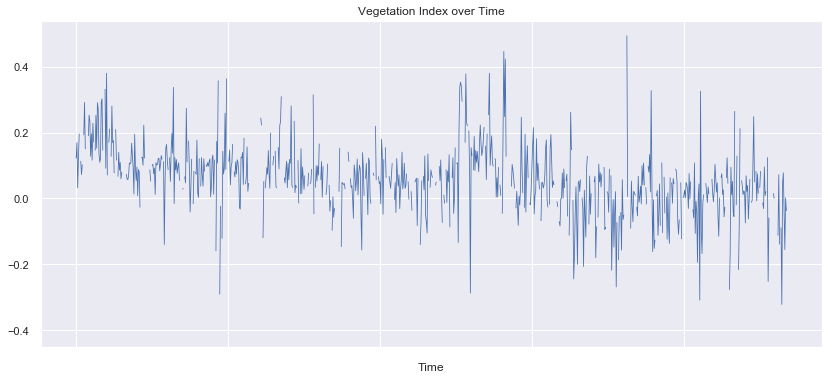

In [8]:
sns.set()
plt.figure(figsize=(14, 6))
(sj_train_features
 .ndvi_ne
 .plot
 .line(lw=0.8))

plt.title('Vegetation Index over Time')
plt.xlabel('Time')

Since these are time-series, we can see the gaps where there are `NaNs` by plotting the data. Since we can't build a model without those values, we'll take a simple approach and just fill those values with the most recent value that we saw up to that point. This is probably a good part of the problem to improve your score by getting smarter.

In [9]:
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)

Our target variable, total_cases is a non-negative integer, which means we're looking to make some count predictions. Standard regression techniques for this type of prediction include

1. Poisson regression 2. Negative binomial regression

Which techniqe will perform better depends on many things, but the choice between Poisson regression and negative binomial regression is pretty straightforward. Poisson regression fits according to the assumption that the mean and variance of the population distributiona are equal. When they aren't, specifically when the variance is much larger than the mean, the negative binomial approach is better. Why? It isn't magic. The negative binomial regression simply lifts the assumption that the population mean and variance are equal, allowing for a larger class of possible models.In fact, from this perspective, the Poisson distribution is but a special case of the negative binomial distribution.

Let's see how our labels are distributed!

In [10]:
print('San Juan')
print('mean: ', sj_train_labels.mean()[0])
print('var :', sj_train_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_train_labels.mean()[0])
print('var :', iq_train_labels.var()[0])

San Juan
mean:  34.18055555555556
var : 2640.045439691045

Iquitos
mean:  7.565384615384615
var : 115.8955239365642


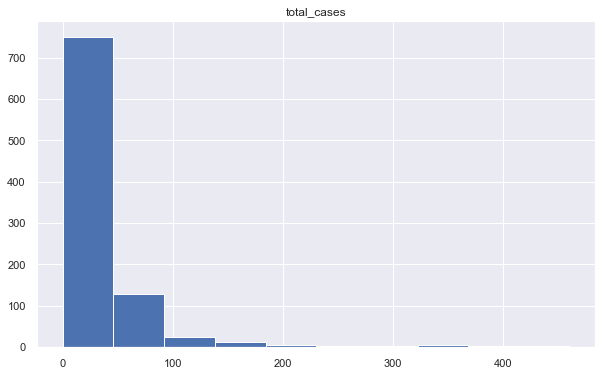

In [11]:
sj_train_labels.hist(figsize=(10, 6));

__`variance >> mean`__ suggests total_cases can be described by a negative binomial distribution, so we'll use a negative binomial regression below.

<a id="feat_select"></a>

---
## Feature Selection

In [12]:
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases

In [13]:
# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

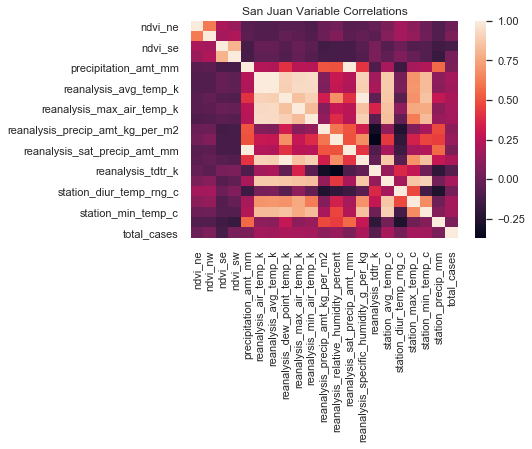

In [14]:
# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations');

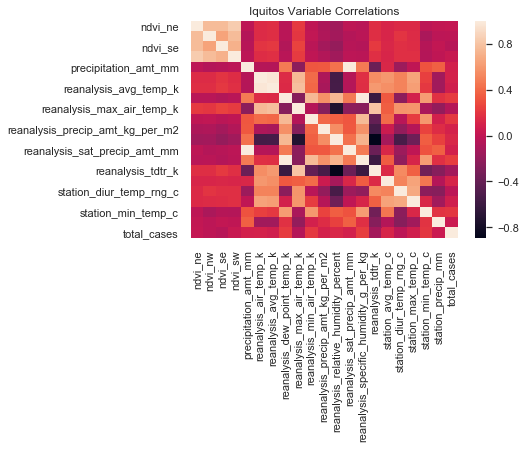

In [15]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations)
plt.title('Iquitos Variable Correlations');

Many of the temperature data are strongly correlated, which is expected. But the __`total_cases`__ variable doesn't have many obvious strong correlations.

Interestingly, __`total_cases`__ seems to only have weak correlations with other variables. Many of the climate variables are much more strongly correlated. Interestingly, the vegetation index also only has weak correlation with other variables. These correlations may give us some hints as to how to improve our model that we'll talk about later in this post. For now, let's take a __`sorted`__ look at __`total_cases`__ correlations.

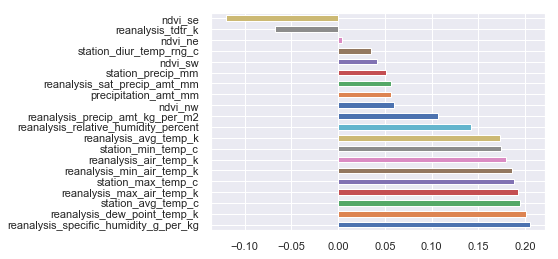

In [16]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh());

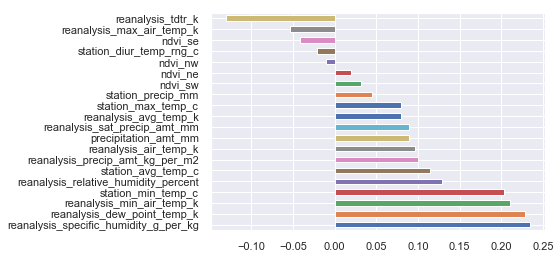

In [17]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh());

### A few observations
__The wetter the better__
The correlation strengths differ for each city, but it looks like __`reanalysis_specific_humidity_g_per_kg`__ and __`reanalysis_dew_point_temp_k`__ are the most strongly correlated with __`total_cases`__. This makes sense: we know mosquitos thrive wet climates, the wetter the better!

__Hot and heavy__
As we all know, "cold and humid" is not a thing. So it's not surprising that as minimum temperatures, maximum temperatures, and average temperatures rise, the __`total_cases`__ of dengue fever tend to rise as well.

__Sometimes it rains, so what__
Interestingly, the __precipitation__ measurements bear little to no correlation to __`total_cases`__, despite strong correlations to the __humidity__ measurements, as evident by the heatmaps above.

__This is just a first pass__
Precisely none of these correlations are very strong. Of course, that doesn't mean that some feature engineering wizardry can't put us in a better place (__standing_water__ estimate, anyone?). Also, it's always useful to keep in mind that life isn't linear, but out-of-the-box correlation measurement is – or at least, it measures linear dependence.

Nevertheless, for this benchmark we'll focus on the linear wetness trend we see above, and reduce our inputs to

__A few good variables__
- __`reanalysis_specific_humidity_g_per_kg`__
- __`reanalysis_dew_point_temp_k`__
- __`station_avg_temp_c`__
- __`station_min_temp_c`__

---

## A MOSQUITO MODEL

Now that we've explored this data, it's time to start modeling. Our first step will be to build a function that does all of the preprocessing we've done above from start to finish. This will make our lives easier, since it needs to be applied to the test set and the traning set before we make our predictions.

In [18]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c']
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [19]:
sj_train, iq_train = preprocess_data(data_path='./data/dengai/features/dengue_features_train.csv', 
                                     labels_path='./data/dengai/labels/dengue_labels_train.csv')

Now we can take a look at the smaller dataset and see that it's ready to start modelling:

In [20]:
sj_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,936.000000,936.000000,936.000000,936.000000,936.000000
mean,16.547535,295.104736,26.999191,22.594017,34.180556
std,1.560663,1.570075,1.415079,1.506281,51.381372
min,11.715714,289.642857,22.842857,17.800000,0.000000
25%,15.233571,293.843929,25.842857,21.700000,9.000000
50%,16.835000,295.451429,27.214286,22.800000,19.000000
75%,17.854286,296.415714,28.175000,23.900000,37.000000
max,19.440000,297.795714,30.071429,25.600000,461.000000


In [21]:
iq_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,520.000000,520.000000,520.000000,520.000000,520.000000
mean,17.102019,295.498723,27.506331,21.210385,7.565385
std,1.443048,1.414360,0.908973,1.257734,10.765478
min,12.111429,290.088571,21.400000,14.700000,0.000000
25%,16.121429,294.596429,26.957500,20.600000,1.000000
50%,17.428571,295.852143,27.587500,21.400000,5.000000
75%,18.180357,296.557143,28.075000,22.000000,9.000000
max,20.461429,298.450000,30.800000,24.200000,116.000000


### SPLIT IT UP!

Since this is a timeseries model, we'll use a strict-future holdout set when we are splitting our train set and our test set. We'll keep around three quarters of the original data for training and use the rest to test. We'll do this separately for our San Juan model and for our Iquitos model.

In [22]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

### TRAINING TIME

This is where we start getting down to business. As we noted above, we'll train a NegativeBinomial model, which is often used for count data where the mean and the variance are very different. In this function we have three steps. The first is to specify the functional form

In [23]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

def get_best_model(train, test):
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Find the best hyper parameter, alpha
    for alpha in grid:
        model = sm.genmod.GLM(endog=train['total_cases'],
                              exog=train[['reanalysis_specific_humidity_g_per_kg', 
                                          'reanalysis_dew_point_temp_k',
                                          'station_avg_temp_c', 
                                          'station_min_temp_c']],
                              family=sm.genmod.families.family.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test.drop(['total_cases'], axis=1)).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = sm.genmod.GLM(endog=full_dataset['total_cases'],
                          exog=full_dataset[['reanalysis_specific_humidity_g_per_kg', 
                                             'reanalysis_dew_point_temp_k', 
                                             'station_avg_temp_c', 
                                             'station_min_temp_c']],
                          family=sm.genmod.families.family.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

best alpha =  1e-08
best score =  22.330882352941178
best alpha =  1e-08
best score =  6.525


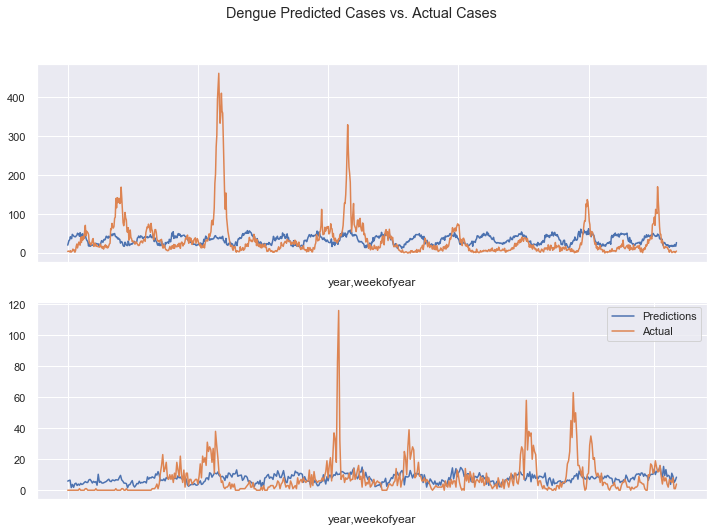

In [24]:
sns.set()
rcParams['figure.figsize'] = 12, 8
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend();

---

## REFLECTING ON OUR PERFORMANCE
These graphs can actually tell us a lot about where our model is going wrong and give us some good hints about where investments will improve the model performance. For example, we see that our model in blue does track the seasonality of Dengue cases. However, the timing of the seasonality of our predictions has a mismatch with the actual results. One potential reason for this is that our features don't look far enough into the past--that is to say, we are asking to predict cases at the same time as we are measuring percipitation. Because dengue is misquito born, and the misquito lifecycle depends on water, we need to take both the life of a misquito and the time between infection and symptoms into account when modeling dengue. This is a critical avenue to explore when improving this model.

The other important error is that our predictions are relatively consistent--we miss the spikes that are large outbreaks. One reason is that we don't take into account the contagiousness of dengue. A possible way to account for this is to build a model that progressively predicts a new value while taking into account the previous prediction. By training on the dengue outbreaks and then using the predicted number of patients in the week before, we can start to model this time dependence that the current model misses.

So, we know we're not going to win this thing, but let's submit the model anyway!

In [25]:
sj_test, iq_test = preprocess_data('./data/dengai/test_features/dengue_features_test.csv')

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

submission = pd.read_csv('./data/dengai/submission_format.csv',
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv('./data/dengai/benchmark.csv')

__Now, let's see how we can improve on this model. In the next part, we'll use the TPOT API to automatically find the best regressor for our data.__